In [1]:
%load_ext nb_black
import os

PAPER_ROOT = os.path.expanduser(os.environ.get("PAPER_ROOT", "."))

<IPython.core.display.Javascript object>

# Comparison of XSMC, PSMC, SMCSMC, SMC++

## Setup code

In [2]:
import numpy as np
import pandas as pd
import msprime as msp
import matplotlib.pyplot as plt
import json

# from scipy.interpolate import interp1d
from xsmc.supporting.plotting import *

<IPython.core.display.Javascript object>

In [3]:
M = 25


def summarize_lines(xys, x0):
    "summarize a collection of lines by plotting their median and IQR"
    y0 = []
    for x, y in xys:
        f = interp1d(
            x, y, bounds_error=False
        )  # interpolate linearly to a common set of points
        y0.append(f(x0))
    return np.nanquantile(y0, [0.5, 0.25, 0.75], axis=0)  # median, q25, q75


def plot_summary(ax, lines, x, label=None, **kwargs):
    all_x = np.concatenate([l[0] for l in lines]).reshape(-1)
    m, q25, q75 = summarize_lines(lines, x)
    ax.plot(x, m / 2, label=label, **kwargs)
    ax.fill_between(x, q25 / 2, q75 / 2, **kwargs, alpha=0.5)


def plot_combined(lines, labels, colors, truth, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.geomspace(1e2, 1e6, 200)
    for lines, label, color in zip(lines, labels, colors):
        plot_summary(ax, lines, x, label=label, color=color)
    ax.plot(
        *truth, "--", color="darkgrey", label="Truth", drawstyle="steps-post", zorder=0
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e2, 1e5)
    ax.set_ylim(1e3, 1e6)

<IPython.core.display.Javascript object>

In [4]:
from xsmc.supporting.kde_ne import *


def parallel_kde(sampled_heights, **kwargs):
    with ProcessPoolExecutor() as p:
        futs = [p.submit(kde_ne, h.reshape(-1), **kwargs) for h in sampled_heights]
        return [(f.result()[0], f.result()[1]) for f in futs]

<IPython.core.display.Javascript object>

In [5]:
psmc1 = np.load("competing/psmc1.npy")
psmc2 = np.load("competing/psmc2.npy")
lines_psmc = [(p1, p2) for p1, p2 in zip(psmc1, psmc2)]

xsmc1 = np.load("competing/xsmc1.npy")
xsmc2 = np.load("competing/xsmc2.npy")
lines_xsmc = [(x1, x2) for x1, x2 in zip(xsmc1, xsmc2)]

<IPython.core.display.Javascript object>

In [6]:
from collections import defaultdict
import pandas as pd

lines_smcsmc = defaultdict(list)
scenarios = ["constant", "growth", "zigzag"]
for s in scenarios:
    for i in range(M):
        df = pd.read_csv(f"competing/smcsmc/output/{s}/output{i}/result.out", sep="\s+")
        df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
        x = df["Start"].to_numpy()
        y = df["Ne"].to_numpy() * 2
        lines_smcsmc[s].append((x, y))

/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc

/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/3243101002.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["Iter"] == max(df["Iter"])][df["Clump"] == -1][df["Type"] == "Coal"]
/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc

<IPython.core.display.Javascript object>

In [7]:
lines_smcpp = defaultdict(list)
for s in scenarios:
    for i in range(M):
        if i != 18:
            with open(f"competing/smcpp/output/{s}/{i}.final.json") as f:
                res = json.load(f)
            scale = 2 * res["model"]["N0"]
            x = np.array(res["model"]["knots"]) * scale
            y = np.array(res["model"]["y"]) * 2 * scale
            lines_smcpp[s].append((x, y))

<IPython.core.display.Javascript object>

## Constant effective population size
The simplest case. First we check the estimator on "perfect" data, that is i.i.d. samples from the true distribution:

In [8]:
de = [msp.PopulationParametersChange(time=0, initial_size=1e4)]

<IPython.core.display.Javascript object>

### Perfect data

Verify the estimator on "perfect" data:

(1000.0, 100000.0)

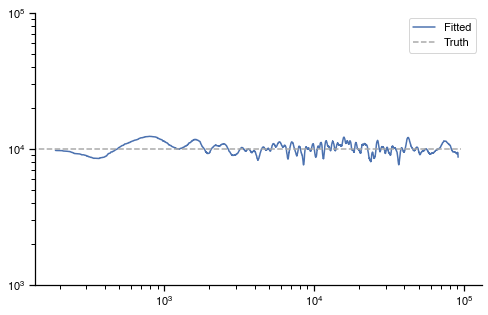

<IPython.core.display.Javascript object>

In [9]:
true_data = np.array(
    [
        next(sim.trees()).get_time(2)
        for sim in msp.simulate(
            num_replicates=10000, demographic_events=de, sample_size=2
        )
    ]
)
x, y = kde_ne(true_data)
plt.plot(x, y / 2, label="Fitted")
plt.plot(plt.xlim(), [1e4] * 2, "--", color="darkgrey", label="Truth")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylim(1e3, 1e5)

/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


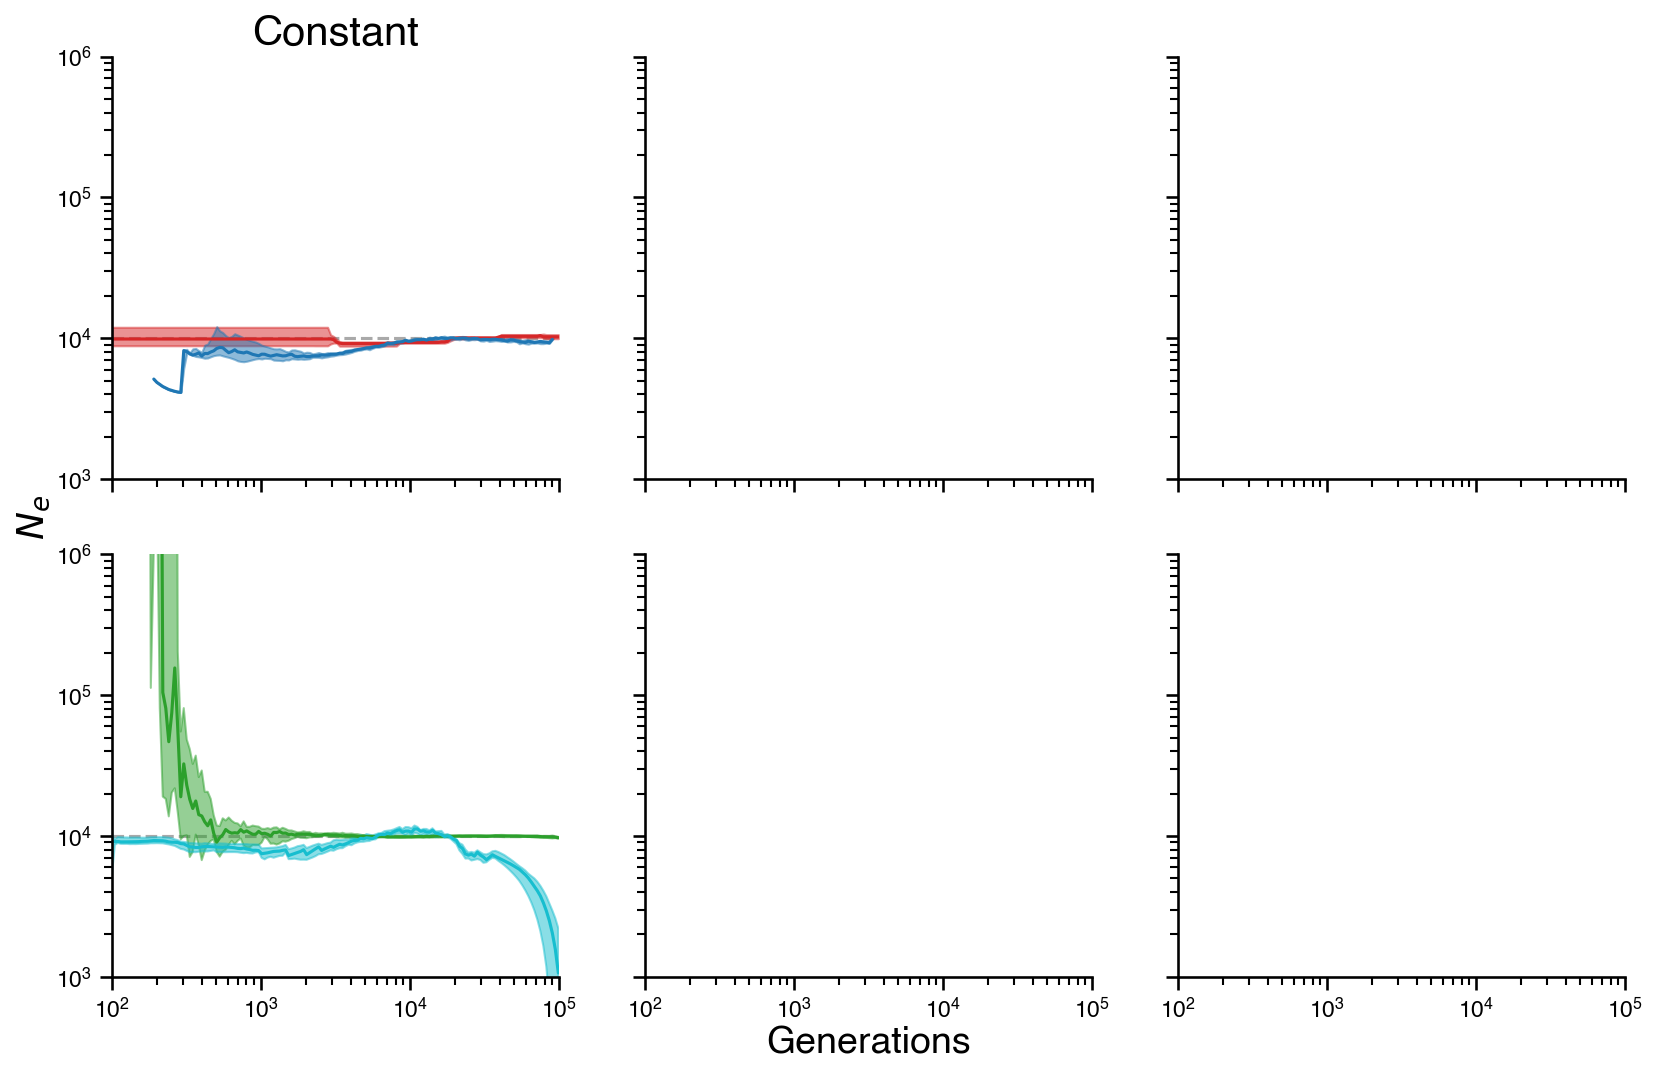

<IPython.core.display.Javascript object>

In [25]:
truth = ([1e2, 1e6], [1e4, 1e4])
fig, axs = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True, dpi=150
)
plot_combined(
    (lines_psmc[:M], lines_xsmc[:M]),
    ("PSMC", "XSMC"),
    ("tab:red", "tab:blue"),
    truth,
    axs[0][0],
)
plot_combined(
    (lines_smcsmc["constant"], lines_smcpp["constant"]),
    ("SMCSMC", "SMC++"),
    ("tab:green", "tab:cyan"),
    truth,
    axs[1][0],
)
# a.legend()
axs[0][0].set_xlim(1e2, 1e5)
axs[0][0].set_ylim(1e3, 1e6)
axs[0][0].set_title("Constant")
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")
# plt.ylabel("common Y")
plt.xlabel("Generations")
plt.ylabel("$N_e$")
plt.tight_layout(pad=1.5)

## Recent growth

### Perfect data

In [26]:
de = [
    msp.PopulationParametersChange(time=0, initial_size=1e6),
    msp.PopulationParametersChange(time=1e3, initial_size=5e3),
    msp.PopulationParametersChange(time=2e3, initial_size=2e4),
]

<IPython.core.display.Javascript object>

In [27]:
true_data = np.array(
    [
        next(sim.trees()).get_time(2)
        for sim in msp.simulate(
            num_replicates=10000, demographic_events=de, sample_size=2, Ne=1
        )
    ]
)

<IPython.core.display.Javascript object>

(100.0, 100000.0)

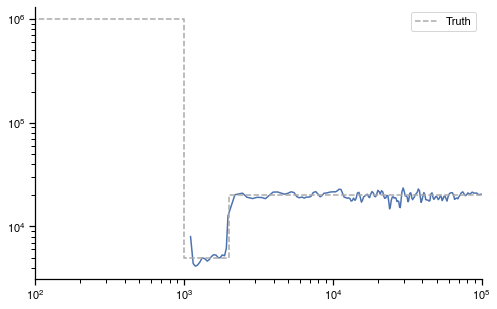

<IPython.core.display.Javascript object>

In [28]:
x, y = kde_ne(true_data)
plt.plot(x[::50], y[::50] / 2)  # downsample the curves to make plotting faster
truth = ([0, 1e3, 2e3, 1e5], [1e6, 5e3, 2e4, 2e4])


plt.plot(
    *truth,
    "--",
    color="darkgrey",
    label="Truth",
    drawstyle="steps-post",
)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(1e2, 1e5)

### Combined plot for paper

/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


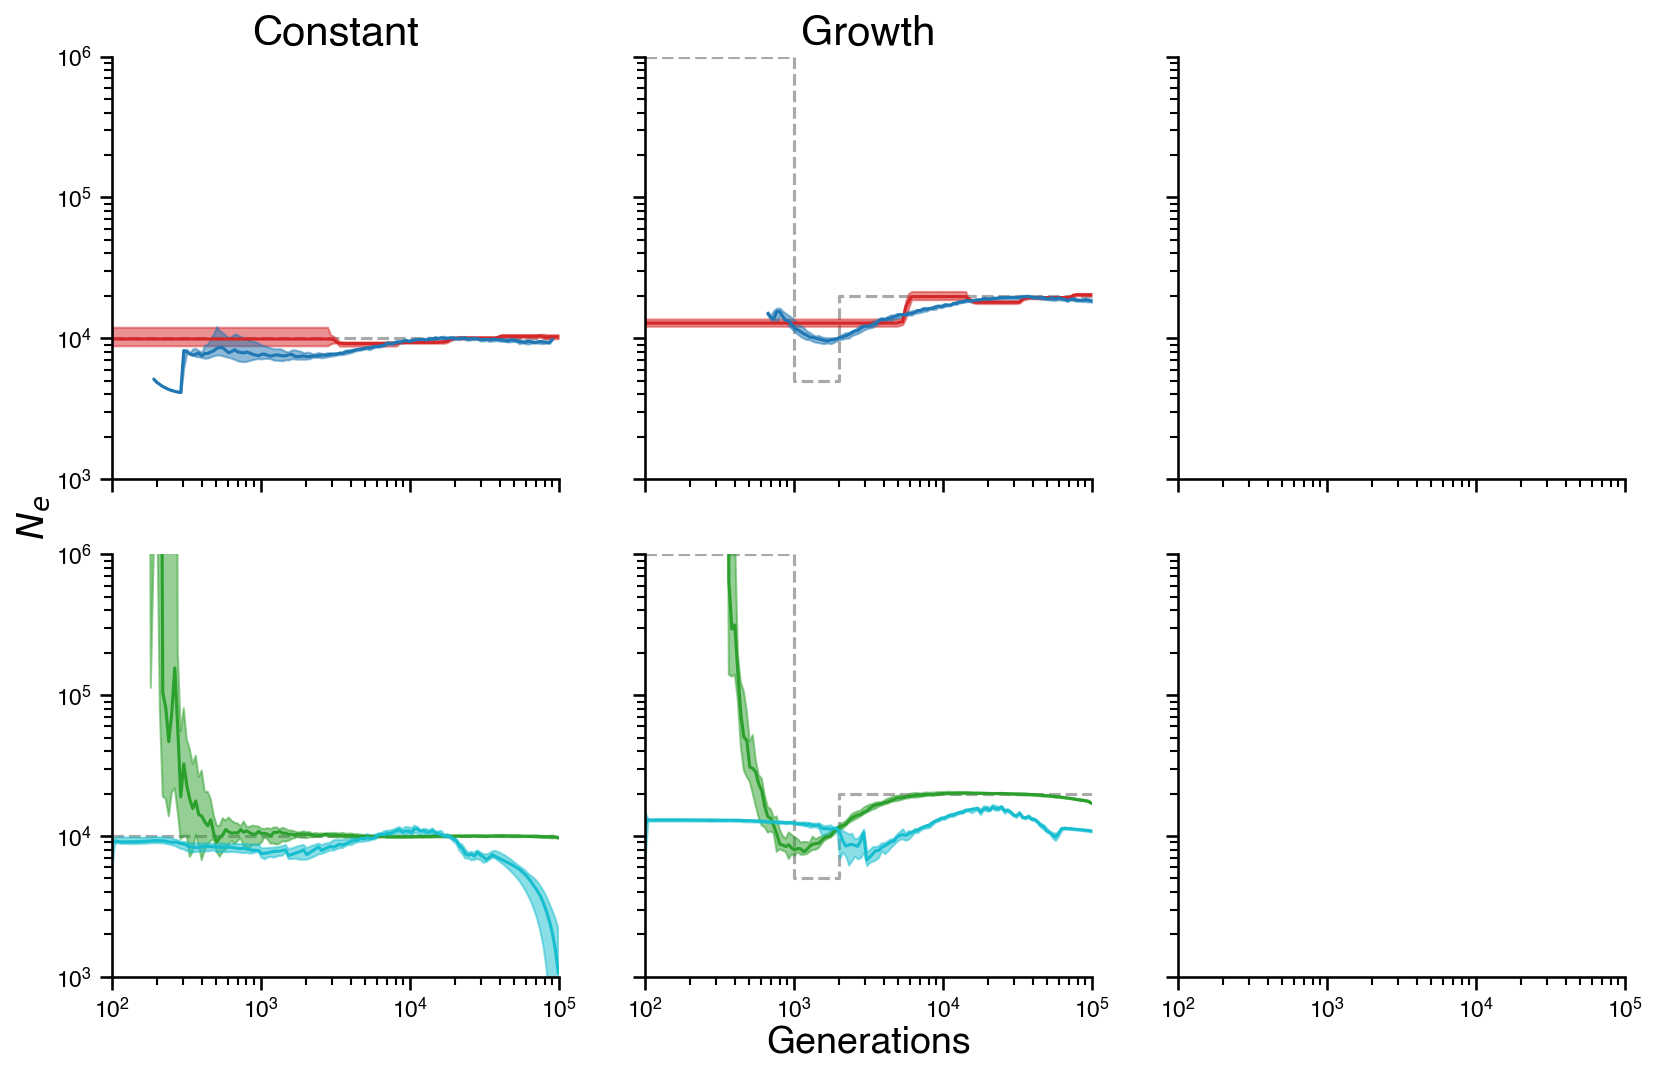

<IPython.core.display.Javascript object>

In [29]:
plot_combined(
    (lines_psmc[M : 2 * M], lines_xsmc[M : 2 * M]),
    ("PSMC", "XSMC"),
    ("tab:red", "tab:blue"),
    truth,
    axs[0][1],
)
plot_combined(
    (lines_smcsmc["growth"], lines_smcpp["growth"]),
    ("SMCSMC", "SMC++"),
    ("tab:green", "tab:cyan"),
    truth,
    axs[1][1],
)

axs[0][1].set_title("Growth")
fig

## Zigzag

In [30]:
import stdpopsim

species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
de = [
    msp.PopulationParametersChange(time=0, initial_size=14312)
] + model.demographic_events


<IPython.core.display.Javascript object>

### Perfect data

In [31]:
true_data = np.array(
    [
        next(sim.trees()).get_time(2)
        for sim in msp.simulate(
            num_replicates=10000,
            demographic_events=de,
            sample_size=2,
        )
    ]
)

<IPython.core.display.Javascript object>

(100.0, 100000.0)

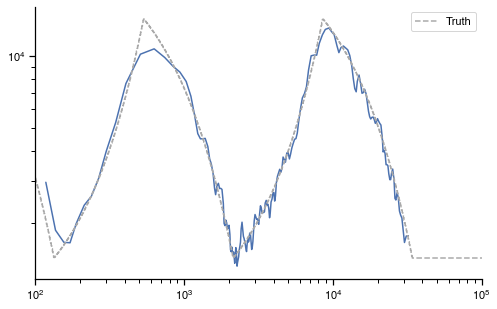

<IPython.core.display.Javascript object>

In [32]:
x, y = kde_ne(true_data)
plt.plot(x[::50], y[::50] / 2)  # downsample the curves to make plotting faster

f = plot_de(de, 14312)
x_zz = np.geomspace(1e2, 1e6, 1000)
truth = (x_zz, f(x_zz))


plt.plot(
    *truth,
    "--",
    color="darkgrey",
    label="Truth",
    drawstyle="steps-post",
)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(1e2, 1e5)

In [33]:
plot_combined(
    (
        lines_psmc[2 * M :],
        lines_xsmc[2 * M :],
    ),
    ("PSMC", "XSMC"),
    ("tab:red", "tab:blue"),
    truth,
    axs[0][2],
)
plot_combined(
    (lines_smcsmc["zigzag"], lines_smcpp["zigzag"]),
    ("SMCSMC", "SMC++"),
    ("tab:green", "tab:cyan"),
    truth,
    axs[1][2],
)

axs[0][2].set_title("Zigzag")

/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/calebki/Desktop/Git/xsmc/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'Zigzag')

<IPython.core.display.Javascript object>

## SMCSMC

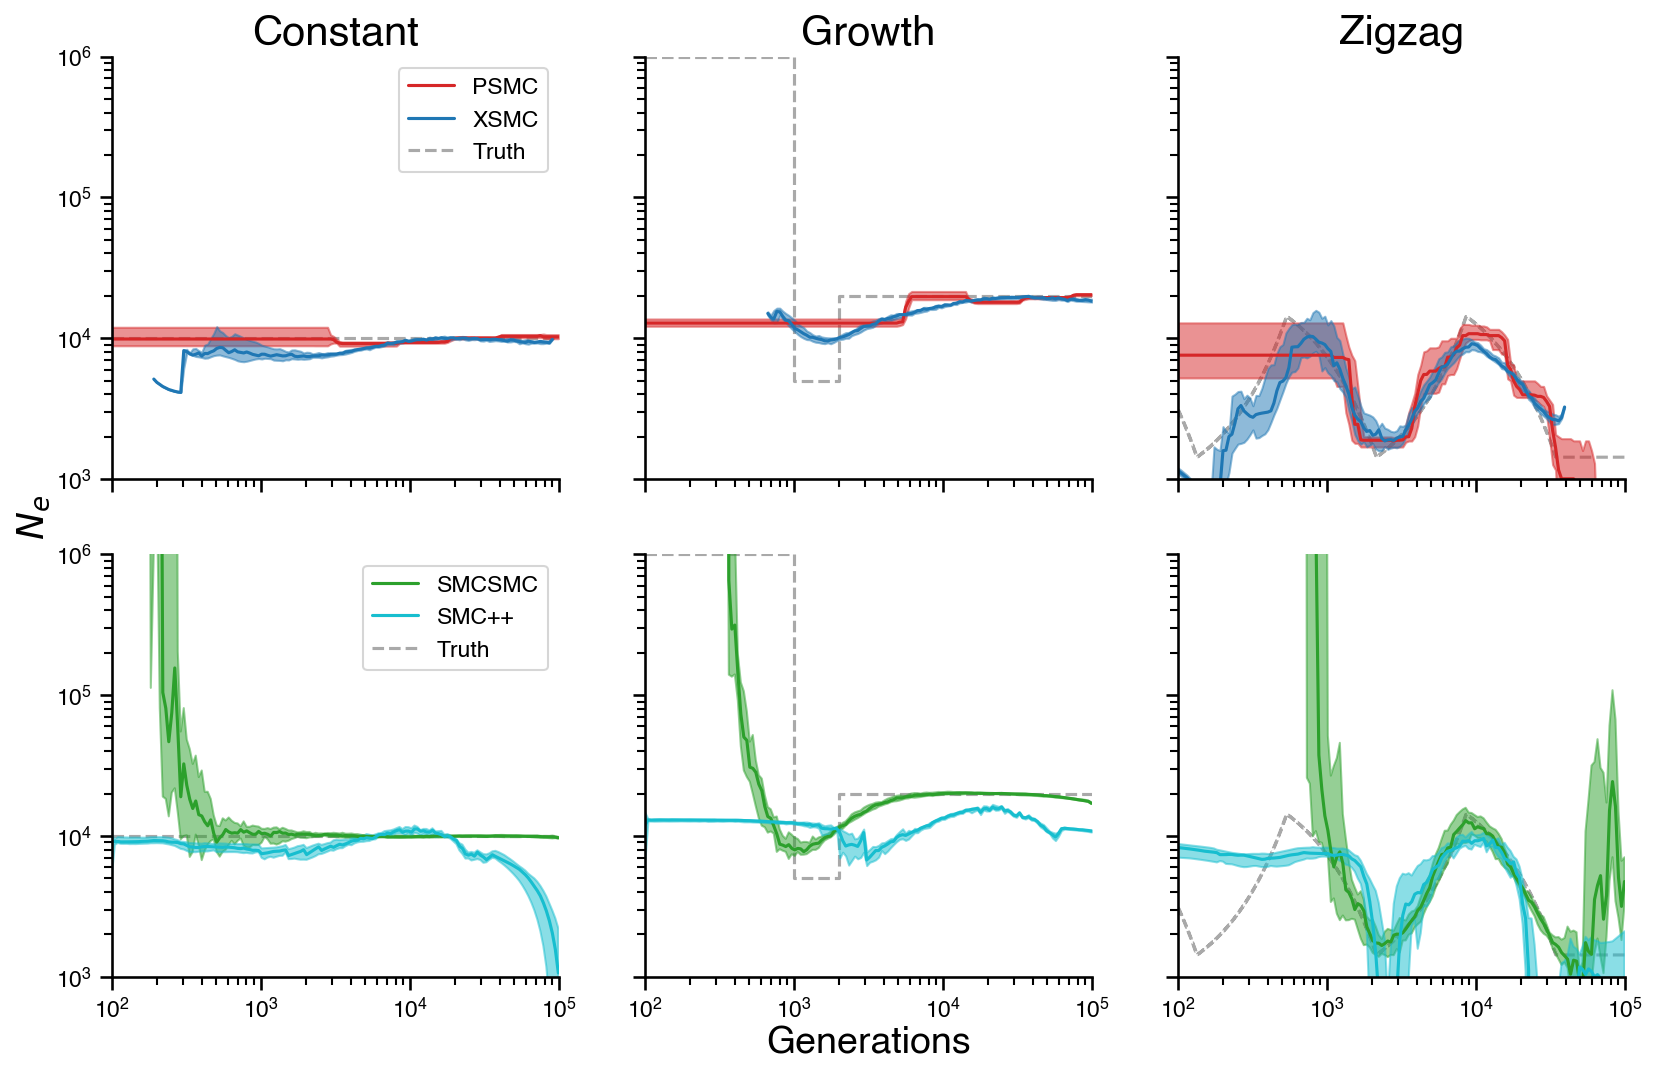

<IPython.core.display.Javascript object>

In [34]:
axs[0][0].legend()
axs[1][0].legend()
fig

In [35]:
folder = "../../../../exact_decoding_paper/figures/psmc/"
fig.savefig(os.path.join(folder, "competing.pdf"))

<IPython.core.display.Javascript object>

## Time Table

In [42]:
times = np.load("competing/times.npy") / 60
columns = ["SMC++", "SMCSMC", "XSMC", "PSMC"]
tab = pd.DataFrame(columns=columns, data=[times])
tab.index = ["Minutes"]
tab = tab.T
tab.index.name = "Method"
tab.reset_index(inplace=True)
tab

,Method,Minutes
0,SMC++,519.865721
1,SMCSMC,1840.547969
2,XSMC,0.891570
3,PSMC,1.401326


<IPython.core.display.Javascript object>

In [49]:
tab.to_latex(os.path.join(folder, "times.tex"), index=False)

/var/folders/cl/0ml94kbd37bdb3f0y3rx3wfc0000gr/T/ipykernel_17888/776930790.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab.to_latex(os.path.join(folder, "times.tex"), index=False)


<IPython.core.display.Javascript object>